# Greenledger Notebook

This notebook is used for exploratory analysis and prototyping around:

- Regional yield features from CSV datasets (e.g., `data/crop_yield_data.csv`)
- Weather/climate risk signals from `data/weather_forecast.csv`
- Feature engineering and blending strategies for credit scoring
- Sanity checks comparing heuristic scores and model artifacts (if available)

Guidelines:
- Keep raw data loading and transformations clearly separated.
- Prefer small, well-named helper functions for reusability.
- Save intermediate artifacts in `../models/` only if they are stable and versioned.
- Ensure any output used by the Node service aligns with `ai/scripts/credit_predictor.py` expectations.



# **THE GREEN LEDGER**
# **AI Powered Credit Score Validation System for Farmers.**

# **1. Setup and Installation.**

In [1]:
# Install required packages
!pip install pandas numpy scikit-learn lightgbm shap matplotlib seaborn plotly scipy gdown

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
import lightgbm as lgb
import shap
import warnings
warnings.filterwarnings('ignore')

print("‚úÖ Packages installed successfully!")

  Using cached pandas-2.3.3-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (91 kB)
  Using cached numpy-2.3.4-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached scikit_learn-1.7.2-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached shap-0.49.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (25 kB)
  Using cached scipy-1.16.3-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (62 kB)
  Using cached gdown-5.2.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
  Using cached numba-0.

/home/toshlewi/Sprout-Sell/Sprout-Sell/ai/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **2. Data Download And Loading.**

In [2]:
import gdown
import os

def download_datasets():
    """Download datasets from Google Drive"""

    # Create data directory
    os.makedirs('/content/data', exist_ok=True)

    # Google Drive folder ID
    folder_id = '1eJyby2jV2cnwpFfsi1hbr0B05XlLPs4n'

    # Download entire folder
    !gdown --folder https://drive.google.com/drive/folders/{folder_id} -O /content/data/ --quiet

    print("üì• Datasets downloaded successfully!")

# Download the data
download_datasets()

# List downloaded files
print("üìÅ Downloaded files:")
for file in os.listdir('/content/data'):
    print(f"  - {file}")

PermissionError: [Errno 13] Permission denied: '/content'

# **3. Feature Engineering** **(Synthetic Data Generation)**

**Synthetic Dataset with Financial history behaviour and Farm details.**

Base Farmer Profiles.

In [ ]:
#base farmer profiles as per their region
from google.colab import files

def generate_synthetic_farmers_dataset(n_farmers=15000):
    """
    Generate comprehensive synthetic dataset for smallholder farmers WITH M-PESA DATA
    """
    np.random.seed(42)

    # Base farmer profiles
    regions = ['Central', 'Rift Valley', 'Western', 'Nyanza', 'Eastern', 'Coast']

    data = {
        'farmer_id': range(n_farmers),
        'region': np.random.choice(regions, n_farmers, p=[0.3, 0.25, 0.15, 0.1, 0.15, 0.05]),
        'age': np.random.randint(25, 65, n_farmers),
        'gender': np.random.choice(['Male', 'Female'], n_farmers, p=[0.7, 0.3]),
        'education_level': np.random.choice(['None', 'Primary', 'Secondary', 'Tertiary'],
                                          n_farmers, p=[0.25, 0.5, 0.2, 0.05]),
        'years_farming': np.random.randint(1, 40, n_farmers),
    }

    df = pd.DataFrame(data)

    #farmer characterist

Farmer Characterstics (Small Scale or Large Scale)

In [ ]:
# Farm characteristics with correlations
def generate_synthetic_farmers_dataset(n_farmers=15000):
    """
    Generate comprehensive synthetic dataset for smallholder farmers WITH M-PESA DATA
    """
    np.random.seed(42)
    df['acreage_ha'] = np.random.lognormal(1.2, 0.8, n_farmers).clip(0.5, 20)
    df['soil_class'] = np.random.choice([1, 2, 3, 4], n_farmers, p=[0.2, 0.4, 0.3, 0.1])

    # Cooperative features (correlated with education)
    education_coop_prob = {'None': 0.1, 'Primary': 0.3, 'Secondary': 0.6, 'Tertiary': 0.8}
    df['coop_member'] = np.random.binomial(1, df['education_level'].map(education_coop_prob))

MPESA Financial Behaviour Data

In [ ]:
def generate_synthetic_dataset(n_farmers=15000):
  """
  Generate comprehensive synthetic data for the Mpesa financial behavious data
  """
  #  Transaction Frequency (farmers transact more during harvest/selling seasons)
  df['mpesa_transactions_per_month'] = np.random.poisson(15, n_farmers)  # 15 transactions/month avg

In [ ]:
 # 2. Transaction Consistency (low std dev = more reliable)
 def generate_synthetic_dataset(n_farmers=15000):
    df['mpesa_consistency_score'] = np.random.beta(3, 1.5, n_farmers)  # 0-1 score

    # 3. Savings Behavior (M-Shwari savings patterns)
    df['mpesa_savings_frequency'] = np.random.poisson(3, n_farmers)  # Saves 3x/month avg
    df['mpesa_avg_savings_balance'] = np.random.lognormal(8.5, 1.0, n_farmers)  # KES 2,000-15,000

    # 4. Bill Payment History (reliability score)
    df['mpesa_bill_payment_score'] = np.random.beta(5, 2, n_farmers)  # Most pay bills on time

    # 5. Income Pattern (regular vs irregular income)
    df['mpesa_income_regularity'] = np.random.beta(4, 2, n_farmers)

    # 6. Network Quality (business vs personal transactions)
    df['mpesa_business_contacts'] = np.random.poisson(8, n_farmers)  # Number of buyer/supplier contacts

In [ ]:
# -*- coding: utf-8 -*-
"""Generate and Download Enhanced Synthetic Dataset with M-Pesa Features"""

import pandas as pd
import numpy as np
from google.colab import files

def generate_synthetic_farmers_dataset(n_farmers=15000):
    """
    Generate comprehensive synthetic dataset for smallholder farmers WITH M-PESA DATA
    """
    np.random.seed(42)

    # Base farmer profiles
    regions = ['Central', 'Rift Valley', 'Western', 'Nyanza', 'Eastern', 'Coast']

    data = {
        'farmer_id': range(n_farmers),
        'region': np.random.choice(regions, n_farmers, p=[0.3, 0.25, 0.15, 0.1, 0.15, 0.05]),
        'age': np.random.randint(25, 65, n_farmers),
        'gender': np.random.choice(['Male', 'Female'], n_farmers, p=[0.7, 0.3]),
        'education_level': np.random.choice(['None', 'Primary', 'Secondary', 'Tertiary'],
                                          n_farmers, p=[0.25, 0.5, 0.2, 0.05]),
        'years_farming': np.random.randint(1, 40, n_farmers),
    }

    df = pd.DataFrame(data)

    # Farm characteristics with correlations
    df['acreage_ha'] = np.random.lognormal(1.2, 0.8, n_farmers).clip(0.5, 20)
    df['soil_class'] = np.random.choice([1, 2, 3, 4], n_farmers, p=[0.2, 0.4, 0.3, 0.1])

    # Cooperative features (correlated with education)
    education_coop_prob = {'None': 0.1, 'Primary': 0.3, 'Secondary': 0.6, 'Tertiary': 0.8}
    df['coop_member'] = np.random.binomial(1, df['education_level'].map(education_coop_prob))

    # ==========  M-PESA FINANCIAL BEHAVIOR DATA ==========

    # 1. Transaction Frequency (farmers transact more during harvest/selling seasons)
    df['mpesa_transactions_per_month'] = np.random.poisson(15, n_farmers)  # 15 transactions/month avg

    # 2. Transaction Consistency (low std dev = more reliable)
    df['mpesa_consistency_score'] = np.random.beta(3, 1.5, n_farmers)  # 0-1 score

    # 3. Savings Behavior (M-Shwari savings patterns)
    df['mpesa_savings_frequency'] = np.random.poisson(3, n_farmers)  # Saves 3x/month avg
    df['mpesa_avg_savings_balance'] = np.random.lognormal(8.5, 1.0, n_farmers)  # KES 2,000-15,000

    # 4. Bill Payment History (reliability score)
    df['mpesa_bill_payment_score'] = np.random.beta(5, 2, n_farmers)  # Most pay bills on time

    # 5. Income Pattern (regular vs irregular income)
    df['mpesa_income_regularity'] = np.random.beta(4, 2, n_farmers)

    # 6. Network Quality (business vs personal transactions)
    df['mpesa_business_contacts'] = np.random.poisson(8, n_farmers)  # Number of buyer/supplier contacts

    # ========== AGRO-CLIMATIC DATA ==========
    df['water_access_index'] = np.random.beta(2, 2, n_farmers)
    df['rainfall_anomaly'] = np.random.normal(0, 1.2, n_farmers)
    df['ndvi_mean'] = np.random.normal(0.6, 0.2, n_farmers).clip(0.2, 0.9)

    # ========== ECONOMIC INDICATORS ==========
    base_yield = df['soil_class'].map({1: 4.0, 2: 3.0, 3: 2.0, 4: 1.0})
    coop_boost = df['coop_member'] * 0.3
    water_boost = df['water_access_index'] * 0.4

    df['expected_yield_t_ha'] = (
        base_yield * (1 + coop_boost + water_boost) +
        np.random.normal(0, 0.4, n_farmers)
    ).clip(0.5, 8.0)

    # Income correlated with M-Pesa activity
    df['expected_income_usd'] = (
        df['expected_yield_t_ha'] * df['acreage_ha'] * 250 *
        (1 + df['mpesa_income_regularity'] * 0.3) +  # Regular income farmers get better prices
        np.random.normal(0, 200, n_farmers)
    ).clip(100, 8000)

    # Convert to Kenyan Shillings for realism
    df['expected_income_kes'] = df['expected_income_usd'] * 115  # Approx USD to KES

    # ========== BEHAVIORAL METRICS ==========
    df['advisory_interactions'] = np.random.poisson(2, n_farmers) + df['coop_member'] * 2

    # ========== CALCULATE DEFAULT PROBABILITY ==========
    df = calculate_default_probability_enhanced(df)

    # Generate default labels
    df['default_12m'] = np.random.binomial(1, df['pd_latent'])

    # Risk stratification
    df['risk_tier'] = pd.cut(df['pd_latent'],
                           bins=[0, 0.05, 0.12, 0.25, 0.4, 1],
                           labels=['A', 'B', 'C', 'D', 'E'])

    #  Credit Score (0-1000 scale)
    df['credit_score'] = ((1 - df['pd_latent']) * 850 + 150).astype(int)  # 150-1000 range

    print(f" ENHANCED Synthetic dataset generated with {len(df)} farmers")
    print(f" Default rate: {df['default_12m'].mean():.2%}")
    print(f" New M-Pesa features added!")

    return df

def calculate_default_probability_enhanced(df):
    """Calculate realistic probability of default WITH M-PESA FACTORS"""
    base_risk = 0.18  # Base default rate

    # üÜï STRONG M-PESA RISK FACTORS
    risk_factors = (
        -df['coop_member'] * 0.20 +           # Coop reduces risk
        -df['mpesa_consistency_score'] * 0.25 +  # üÜï Transaction consistency = BIG impact
        -df['mpesa_bill_payment_score'] * 0.20 + # üÜï Bill payment history = BIG impact
        -df['mpesa_income_regularity'] * 0.15 +  # üÜï Regular income reduces risk
        -df['mpesa_savings_frequency'] * 0.10 +  # üÜï Savings habit reduces risk
        -df['water_access_index'] * 0.12 +    # Irrigation reduces risk
        (df['soil_class'] - 1) * 0.08 +       # Poor soil increases risk
        (df['years_farming'] < 3) * 0.10 +    # Inexperience increases risk
        np.abs(df['rainfall_anomaly']) * 0.06 + # Weather volatility
        (df['education_level'] == 'None') * 0.08 + # No education increases risk
        np.random.logistic(0, 0.06, len(df))  # Random noise
    )

    # Convert to probability using logistic function
    df['pd_latent'] = 1 / (1 + np.exp(-(base_risk + risk_factors)))
    df['pd_latent'] = df['pd_latent'].clip(0.02, 0.85)

    return df

# Generate the ENHANCED synthetic dataset
print(" Generating ENHANCED synthetic farmer dataset with M-Pesa data...")
farmers_df = generate_synthetic_farmers_dataset(15000)

# Display dataset overview
print("\n ENHANCED Dataset Overview:")
print(f"Shape: {farmers_df.shape}")
print(f"Default rate: {farmers_df['default_12m'].mean():.2%}")

# Show new M-Pesa features
mpesa_features = [col for col in farmers_df.columns if 'mpesa' in col]
print(f" M-Pesa features: {len(mpesa_features)} features")
for feature in mpesa_features:
    print(f"   - {feature}")

# Display sample of the data
print("\n Sample of the dataset:")
print(farmers_df.head(3))

# ========== DOWNLOAD AS CSV ==========
def download_dataset(df, filename="greenledger_synthetic_farmers.csv"):
    """Download the dataset as CSV"""

    # Create a cleaned version for download
    download_df = df.copy()

    # Add description to the CSV
    description = f"""
# GreenLedger Synthetic Farmer Dataset
# Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
# Total Farmers: {len(df)}
# Default Rate: {df['default_12m'].mean():.2%}
# Features: {len(df.columns)}
#
# Column Descriptions:
# - farmer_id: Unique identifier for each farmer
# - region: Geographic region in Kenya
# - mpesa_*: M-Pesa financial behavior metrics
# - expected_income_kes: Expected annual income in Kenyan Shillings
# - pd_latent: Probability of default (0-1)
# - default_12m: Actual default outcome (0=No, 1=Yes)
# - risk_tier: Credit risk category (A=Best, E=Worst)
# - credit_score: Credit score (150-1000 scale)
#
# This is synthetic data for the CHAI Agritech Hackathon.
"""

    print(f"\n Preparing download: {filename}")
    print(f" File size: {len(df)} rows √ó {len(df.columns)} columns")

    # Save to CSV
    download_df.to_csv(filename, index=False)

    # Download the file
    files.download(filename)

    print(f" Download initiated: {filename}")
    print(" Check your downloads folder for the CSV file!")

# Download the dataset
download_dataset(farmers_df)

# ========== ADDITIONAL: Download a sample for quick testing ==========
def download_sample_dataset(df, sample_size=1000, filename="greenledger_sample_farmers.csv"):
    """Download a smaller sample dataset for quick testing"""

    sample_df = df.sample(sample_size, random_state=42).reset_index(drop=True)

    print(f"\n Also downloading sample dataset ({sample_size} farmers)...")
    sample_df.to_csv(filename, index=False)
    files.download(filename)

    print(f"Sample dataset downloaded: {filename}")

# Download sample version
download_sample_dataset(farmers_df, 1000)

# ========== DATASET SUMMARY STATISTICS ==========
print("\n DATASET SUMMARY STATISTICS:")
print("=" * 50)

# Basic stats
print(f"Total Farmers: {len(farmers_df):,}")
print(f"Default Rate: {farmers_df['default_12m'].mean():.2%}")
print(f"Average Credit Score: {farmers_df['credit_score'].mean():.0f}")

# Risk tier distribution
print(f"\n Risk Tier Distribution:")
risk_dist = farmers_df['risk_tier'].value_counts().sort_index()
for tier, count in risk_dist.items():
    percentage = (count / len(farmers_df)) * 100
    print(f"  Tier {tier}: {count:,} farmers ({percentage:.1f}%)")

# M-Pesa statistics
print(f"\n M-Pesa Behavior Summary:")
print(f"  Avg Transactions/Month: {farmers_df['mpesa_transactions_per_month'].mean():.1f}")
print(f"  Avg Savings Frequency: {farmers_df['mpesa_savings_frequency'].mean():.1f}/month")
print(f"  Avg Bill Payment Score: {farmers_df['mpesa_bill_payment_score'].mean():.2f}")

# Regional distribution
print(f"\n Regional Distribution:")
region_dist = farmers_df['region'].value_counts()
for region, count in region_dist.items():
    percentage = (count / len(farmers_df)) * 100
    print(f"  {region}: {count:,} farmers ({percentage:.1f}%)")

print("\n Your dataset is ready to share with the team!")
print(" Share the CSV files with your teammates for analysis")

 Generating ENHANCED synthetic farmer dataset with M-Pesa data...
 ENHANCED Synthetic dataset generated with 15000 farmers
 Default rate: 38.13%
 New M-Pesa features added!

 ENHANCED Dataset Overview:
Shape: (15000, 27)
Default rate: 38.13%
 M-Pesa features: 7 features
   - mpesa_transactions_per_month
   - mpesa_consistency_score
   - mpesa_savings_frequency
   - mpesa_avg_savings_balance
   - mpesa_bill_payment_score
   - mpesa_income_regularity
   - mpesa_business_contacts

 Sample of the dataset:
   farmer_id       region  age  gender education_level  years_farming  \
0          0  Rift Valley   52    Male            None             11   
1          1        Coast   46    Male            None             10   
2          2       Nyanza   40  Female         Primary              4   

   acreage_ha  soil_class  coop_member  mpesa_transactions_per_month  ...  \
0    3.060687           3            0                            15  ...   
1    6.151359           2            0        

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 Download initiated: greenledger_synthetic_farmers.csv
 Check your downloads folder for the CSV file!

 Also downloading sample dataset (1000 farmers)...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Sample dataset downloaded: greenledger_sample_farmers.csv

 DATASET SUMMARY STATISTICS:
Total Farmers: 15,000
Default Rate: 38.13%
Average Credit Score: 672

 Risk Tier Distribution:
  Tier A: 0 farmers (0.0%)
  Tier B: 0 farmers (0.0%)
  Tier C: 165 farmers (1.1%)
  Tier D: 8,707 farmers (58.0%)
  Tier E: 6,128 farmers (40.9%)

 M-Pesa Behavior Summary:
  Avg Transactions/Month: 15.0
  Avg Savings Frequency: 3.0/month
  Avg Bill Payment Score: 0.71

 Regional Distribution:
  Central: 4,556 farmers (30.4%)
  Rift Valley: 3,808 farmers (25.4%)
  Eastern: 2,255 farmers (15.0%)
  Western: 2,224 farmers (14.8%)
  Nyanza: 1,419 farmers (9.5%)
  Coast: 738 farmers (4.9%)

 Your dataset is ready to share with the team!
 Share the CSV files with your teammates for analysis


# **4. Exploratory Data Analysis.**

 STARTING COMPREHENSIVE DATA CLEANING PIPELINE
 Starting comprehensive data cleaning...

1.  Basic Data Quality Checks:
   Original shape: (15000, 27)
   Missing values: 0
   Duplicate rows: 0
    No missing values found

2. üîß Data Type Validation:

3.  Outlier Detection:
     acreage_ha: 929 outliers (6.19%)
     mpesa_transactions_per_month: 27 outliers (0.18%)
     mpesa_consistency_score: 16 outliers (0.11%)
     mpesa_savings_frequency: 178 outliers (1.19%)
     mpesa_avg_savings_balance: 1181 outliers (7.87%)
     mpesa_bill_payment_score: 108 outliers (0.72%)
     mpesa_income_regularity: 38 outliers (0.25%)
     mpesa_business_contacts: 57 outliers (0.38%)
     rainfall_anomaly: 103 outliers (0.69%)
     expected_yield_t_ha: 8 outliers (0.05%)
     advisory_interactions: 23 outliers (0.15%)
     pd_latent: 65 outliers (0.43%)
     credit_score: 59 outliers (0.39%)

4.  Logical Constraints Validation:
     5076 rows with impossible farming experience

5. üìù Categorical Data

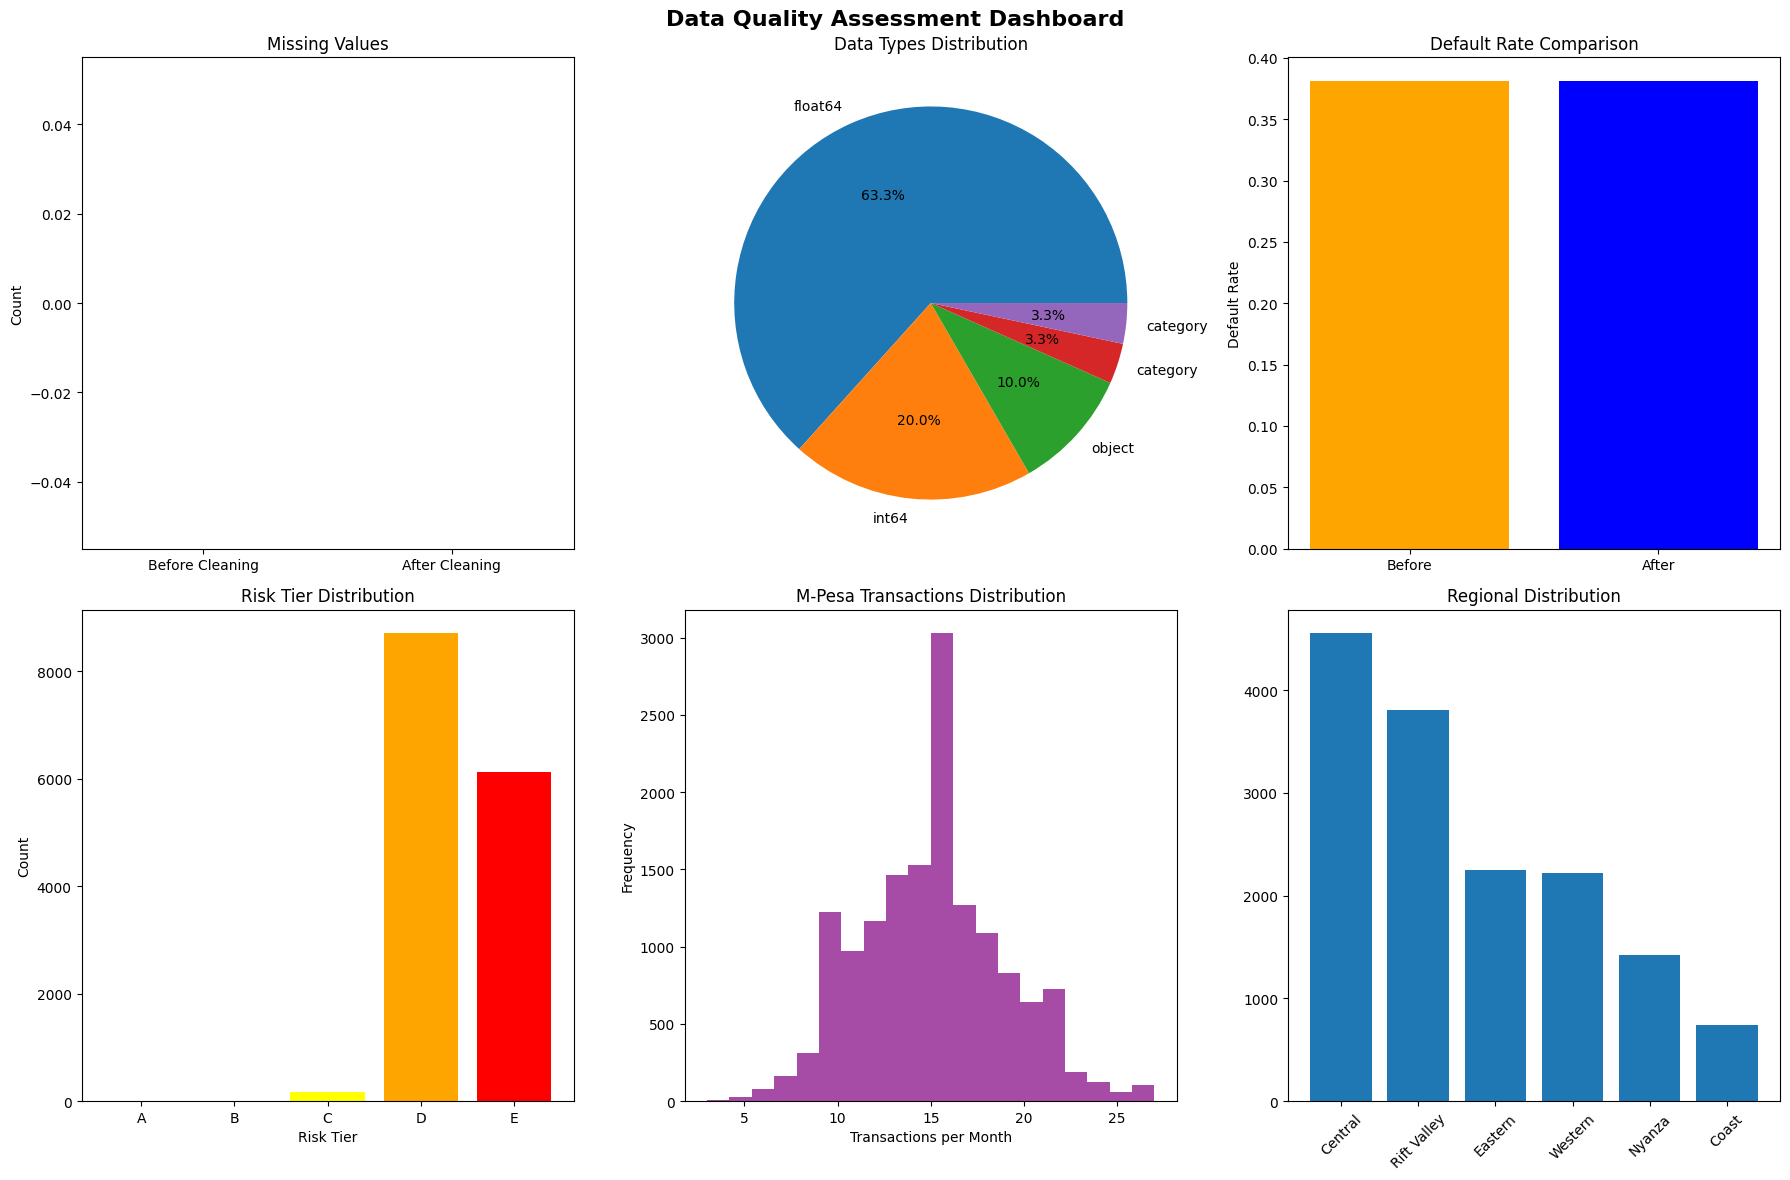


üì¶ Exporting Final Datasets for Team...
 Final datasets exported:
   - greenledger_final_cleaned.csv (Full cleaned dataset)
   - greenledger_final_sample.csv (1000-record sample)
   - greenledger_modeling_ready.csv (Key features for ML)
   - greenledger_data_dictionary.csv (Column descriptions)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   üì• Downloaded: greenledger_final_cleaned.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   üì• Downloaded: greenledger_final_sample.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   üì• Downloaded: greenledger_modeling_ready.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   üì• Downloaded: greenledger_data_dictionary.csv

 DATA CLEANING COMPLETE!
 Your datasets are now cleaned, validated, and ready for machine learning!


In [ ]:
# ========== COMPREHENSIVE DATA CLEANING PIPELINE ==========

def comprehensive_data_cleaning(df):
    """
    Comprehensive cleaning pipeline for synthetic farmer data
    """
    print(" Starting comprehensive data cleaning...")
    original_shape = df.shape
    df_clean = df.copy()

    # 1. BASIC DATA QUALITY CHECKS
    print("\n1.  Basic Data Quality Checks:")
    print(f"   Original shape: {df_clean.shape}")
    print(f"   Missing values: {df_clean.isnull().sum().sum()}")
    print(f"   Duplicate rows: {df_clean.duplicated().sum()}")

    # 2. HANDLE MISSING VALUES (though synthetic data shouldn't have any)
    missing_cols = df_clean.columns[df_clean.isnull().any()].tolist()
    if missing_cols:
        print(f"   Found missing values in: {missing_cols}")
        # For numeric columns, fill with median
        # For categorical, fill with mode
        for col in missing_cols:
            if df_clean[col].dtype in ['int64', 'float64']:
                df_clean[col].fillna(df_clean[col].median(), inplace=True)
            else:
                df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)
    else:
        print("    No missing values found")

    # 3. DATA TYPE VALIDATION
    print("\n2. üîß Data Type Validation:")
    expected_types = {
        'farmer_id': 'int64',
        'age': 'int64',
        'years_farming': 'int64',
        'acreage_ha': 'float64',
        'expected_income_usd': 'float64',
        'default_12m': 'int64'
    }

    for col, expected_type in expected_types.items():
        if col in df_clean.columns:
            current_type = str(df_clean[col].dtype)
            if expected_type not in current_type:
                print(f"     {col}: expected {expected_type}, got {current_type}")
                # Convert to correct type
                if 'int' in expected_type:
                    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce').fillna(0).astype(expected_type)
                elif 'float' in expected_type:
                    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce').fillna(0.0).astype(expected_type)

    # 4. OUTLIER DETECTION AND TREATMENT
    print("\n3.  Outlier Detection:")
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()

    # Remove farmer_id from numeric analysis
    if 'farmer_id' in numeric_cols:
        numeric_cols.remove('farmer_id')
    if 'default_12m' in numeric_cols:
        numeric_cols.remove('default_12m')

    outlier_report = {}
    for col in numeric_cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)]
        outlier_count = len(outliers)

        if outlier_count > 0:
            outlier_report[col] = outlier_count
            print(f"     {col}: {outlier_count} outliers ({outlier_count/len(df_clean):.2%})")

            # Cap outliers instead of removing (since it's synthetic data)
            df_clean[col] = np.where(df_clean[col] < lower_bound, lower_bound, df_clean[col])
            df_clean[col] = np.where(df_clean[col] > upper_bound, upper_bound, df_clean[col])

    if not outlier_report:
        print("    No significant outliers found")

    # 5. VALIDATE LOGICAL CONSTRAINTS
    print("\n4.  Logical Constraints Validation:")

    # Age validation
    invalid_age = df_clean[(df_clean['age'] < 18) | (df_clean['age'] > 100)]
    if len(invalid_age) > 0:
        print(f"     {len(invalid_age)} rows with invalid age")
        df_clean['age'] = df_clean['age'].clip(18, 100)

    # Years farming validation (can't be more than age-18)
    invalid_years = df_clean[df_clean['years_farming'] > (df_clean['age'] - 18)]
    if len(invalid_years) > 0:
        print(f"     {len(invalid_years)} rows with impossible farming experience")
        df_clean['years_farming'] = np.minimum(df_clean['years_farming'], df_clean['age'] - 18)

    # Probability bounds
    if 'pd_latent' in df_clean.columns:
        invalid_pd = df_clean[(df_clean['pd_latent'] < 0) | (df_clean['pd_latent'] > 1)]
        if len(invalid_pd) > 0:
            print(f"     {len(invalid_pd)} rows with invalid probability")
            df_clean['pd_latent'] = df_clean['pd_latent'].clip(0, 1)

    # 6. CATEGORICAL DATA VALIDATION
    print("\n5. üìù Categorical Data Validation:")

    categorical_checks = {
        'region': ['Central', 'Rift Valley', 'Western', 'Nyanza', 'Eastern', 'Coast'],
        'gender': ['Male', 'Female'],
        'education_level': ['None', 'Primary', 'Secondary', 'Tertiary'],
        'risk_tier': ['A', 'B', 'C', 'D', 'E']
    }

    for col, expected_values in categorical_checks.items():
        if col in df_clean.columns:
            unique_values = df_clean[col].unique()
            unexpected = set(unique_values) - set(expected_values)
            if unexpected:
                print(f"     {col}: unexpected values {unexpected}")
                # Replace unexpected values with mode
                mode_value = df_clean[col].mode()[0]
                df_clean[col] = df_clean[col].apply(lambda x: x if x in expected_values else mode_value)

    # 7. FEATURE ENGINEERING & ENHANCEMENT
    print("\n6.  Feature Engineering:")

    # Create derived features
    if all(col in df_clean.columns for col in ['expected_income_usd', 'acreage_ha']):
        df_clean['income_per_hectare'] = df_clean['expected_income_usd'] / df_clean['acreage_ha']
        print("    Added: income_per_hectare")

    if all(col in df_clean.columns for col in ['mpesa_transactions_per_month', 'mpesa_consistency_score']):
        df_clean['mpesa_engagement_score'] = (
            df_clean['mpesa_transactions_per_month'] * df_clean['mpesa_consistency_score']
        )
        print("    Added: mpesa_engagement_score")

    # Create age groups
    df_clean['age_group'] = pd.cut(df_clean['age'],
                                  bins=[18, 30, 45, 60, 100],
                                  labels=['Young', 'Middle', 'Senior', 'Elderly'])
    print("    Added: age_group")

    # 8. FINAL DATA QUALITY REPORT
    print("\n7.  Final Data Quality Report:")
    print(f"   Original shape: {original_shape}")
    print(f"   Cleaned shape: {df_clean.shape}")
    print(f"   Rows removed: {original_shape[0] - df_clean.shape[0]}")
    print(f"   Columns added: {df_clean.shape[1] - original_shape[1]}")
    print(f"   Missing values: {df_clean.isnull().sum().sum()}")

    return df_clean

# Run the comprehensive cleaning
print(" STARTING COMPREHENSIVE DATA CLEANING PIPELINE")
print("=" * 60)

cleaned_farmers_df = comprehensive_data_cleaning(farmers_df)

# Save the cleaned dataset
cleaned_farmers_df.to_csv('greenledger_cleaned_farmers.csv', index=False)
print("\n Cleaned dataset saved as: greenledger_cleaned_farmers.csv")

# ========== DATA QUALITY VISUALIZATION ==========

def create_data_quality_dashboard(df_before, df_after):
    """Create visualizations to show data quality improvements"""

    print("\n Creating Data Quality Dashboard...")

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Data Quality Assessment Dashboard', fontsize=16, fontweight='bold')

    # 1. Missing values comparison
    missing_before = df_before.isnull().sum().sum()
    missing_after = df_after.isnull().sum().sum()

    axes[0,0].bar(['Before Cleaning', 'After Cleaning'], [missing_before, missing_after], color=['red', 'green'])
    axes[0,0].set_title('Missing Values')
    axes[0,0].set_ylabel('Count')

    # 2. Data types overview
    dtypes_count = df_after.dtypes.value_counts()
    axes[0,1].pie(dtypes_count.values, labels=dtypes_count.index, autopct='%1.1f%%')
    axes[0,1].set_title('Data Types Distribution')

    # 3. Default rate distribution
    default_rate_before = df_before['default_12m'].mean()
    default_rate_after = df_after['default_12m'].mean()

    axes[0,2].bar(['Before', 'After'], [default_rate_before, default_rate_after], color=['orange', 'blue'])
    axes[0,2].set_title('Default Rate Comparison')
    axes[0,2].set_ylabel('Default Rate')

    # 4. Risk tier distribution
    risk_dist = df_after['risk_tier'].value_counts().sort_index()
    axes[1,0].bar(risk_dist.index, risk_dist.values, color=['green', 'lightgreen', 'yellow', 'orange', 'red'])
    axes[1,0].set_title('Risk Tier Distribution')
    axes[1,0].set_xlabel('Risk Tier')
    axes[1,0].set_ylabel('Count')

    # 5. M-Pesa activity distribution
    if 'mpesa_transactions_per_month' in df_after.columns:
        axes[1,1].hist(df_after['mpesa_transactions_per_month'], bins=20, alpha=0.7, color='purple')
        axes[1,1].set_title('M-Pesa Transactions Distribution')
        axes[1,1].set_xlabel('Transactions per Month')
        axes[1,1].set_ylabel('Frequency')

    # 6. Regional distribution
    region_dist = df_after['region'].value_counts()
    axes[1,2].bar(region_dist.index, region_dist.values)
    axes[1,2].set_title('Regional Distribution')
    axes[1,2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

# Create the dashboard
create_data_quality_dashboard(farmers_df, cleaned_farmers_df)

# ========== FINAL DATASET EXPORT ==========

def export_final_datasets(cleaned_df):
    """Export final cleaned datasets for the team"""

    print("\nüì¶ Exporting Final Datasets for Team...")

    # 1. Full cleaned dataset
    cleaned_df.to_csv('greenledger_final_cleaned.csv', index=False)

    # 2. Sample dataset (1000 records)
    sample_df = cleaned_df.sample(1000, random_state=42)
    sample_df.to_csv('greenledger_final_sample.csv', index=False)

    # 3. Dataset with only key features for modeling
    key_features = [
        'farmer_id', 'region', 'age', 'gender', 'education_level', 'years_farming',
        'acreage_ha', 'soil_class', 'coop_member', 'water_access_index',
        'expected_income_usd', 'mpesa_transactions_per_month', 'mpesa_consistency_score',
        'mpesa_bill_payment_score', 'mpesa_income_regularity', 'pd_latent',
        'default_12m', 'risk_tier', 'credit_score'
    ]

    # Only include columns that exist
    available_features = [col for col in key_features if col in cleaned_df.columns]
    modeling_df = cleaned_df[available_features]
    modeling_df.to_csv('greenledger_modeling_ready.csv', index=False)

    # 4. Create a data dictionary
    data_dict = {
        'Column Name': [],
        'Data Type': [],
        'Description': [],
        'Example Values': []
    }

    for col in cleaned_df.columns:
        data_dict['Column Name'].append(col)
        data_dict['Data Type'].append(str(cleaned_df[col].dtype))
        data_dict['Description'].append(get_column_description(col))
        data_dict['Example Values'].append(str(cleaned_df[col].iloc[:3].tolist()))

    data_dict_df = pd.DataFrame(data_dict)
    data_dict_df.to_csv('greenledger_data_dictionary.csv', index=False)

    print(" Final datasets exported:")
    print("   - greenledger_final_cleaned.csv (Full cleaned dataset)")
    print("   - greenledger_final_sample.csv (1000-record sample)")
    print("   - greenledger_modeling_ready.csv (Key features for ML)")
    print("   - greenledger_data_dictionary.csv (Column descriptions)")

    # Download all files
    files_to_download = [
        'greenledger_final_cleaned.csv',
        'greenledger_final_sample.csv',
        'greenledger_modeling_ready.csv',
        'greenledger_data_dictionary.csv'
    ]

    for file in files_to_download:
        if os.path.exists(file):
            files.download(file)
            print(f"   üì• Downloaded: {file}")

def get_column_description(column_name):
    """Get description for each column"""
    descriptions = {
        'farmer_id': 'Unique identifier for each farmer',
        'region': 'Geographic region in Kenya',
        'age': 'Age of the farmer in years',
        'gender': 'Gender of the farmer',
        'education_level': 'Highest education level completed',
        'years_farming': 'Years of farming experience',
        'acreage_ha': 'Farm size in hectares',
        'soil_class': 'Soil quality (1=Best, 4=Worst)',
        'coop_member': 'Whether farmer is cooperative member (1=Yes, 0=No)',
        'mpesa_transactions_per_month': 'Average M-Pesa transactions per month',
        'mpesa_consistency_score': 'Transaction regularity score (0-1)',
        'mpesa_bill_payment_score': 'Bill payment reliability score (0-1)',
        'mpesa_income_regularity': 'Income pattern consistency (0-1)',
        'water_access_index': 'Water access quality (0-1)',
        'expected_income_usd': 'Expected annual income in USD',
        'pd_latent': 'Probability of default (0-1)',
        'default_12m': 'Actual default outcome (1=Default, 0=No Default)',
        'risk_tier': 'Credit risk category (A=Best, E=Worst)',
        'credit_score': 'Credit score (150-1000 scale)'
    }
    return descriptions.get(column_name, 'Additional feature')

# Export final datasets
export_final_datasets(cleaned_farmers_df)

print("\n DATA CLEANING COMPLETE!")
print(" Your datasets are now cleaned, validated, and ready for machine learning!")

 LOADING CLEANED DATASET...
 Loaded: 15000 farmers, 19 features

üîç PERFORMING ADVANCED FEATURE SELECTION...
üéØ TOP 10 MOST IMPORTANT FEATURES:
   1. mpesa_income_regularity: 0.0924
   2. mpesa_consistency_score: 0.0916
   3. mpesa_bill_payment_score: 0.0904
   4. water_access_index: 0.0903
   5. pd_latent: 0.0877
   6. acreage_ha: 0.0838
   7. expected_income_usd: 0.0778
   8. credit_score: 0.0735
   9. age: 0.0699
   10. years_farming: 0.0685
üöÄ TRAINING OPTIMIZED MODELS...

ü§ñ TRAINING LIGHTGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4576, number of negative: 7424
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2142
[LightGBM] [Info] Number of data points in the train set: 12000, number of us

<Figure size 1000x800 with 0 Axes>

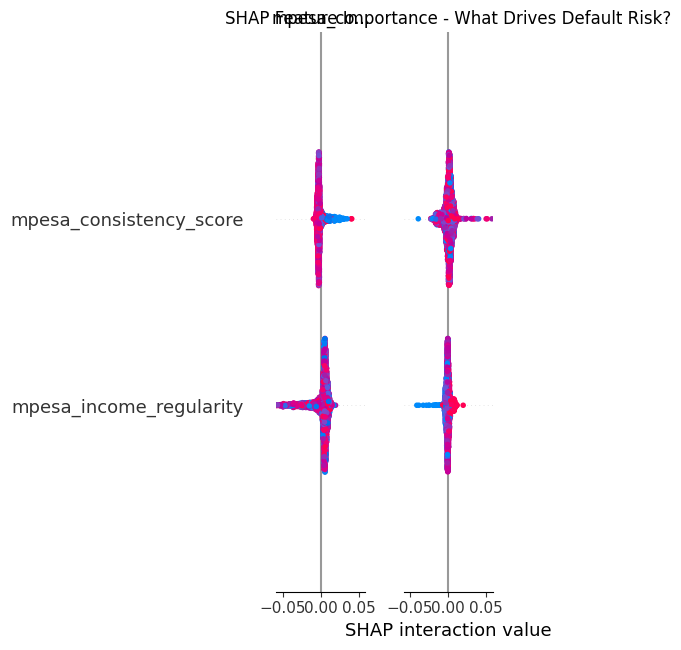

<Figure size 1000x600 with 0 Axes>

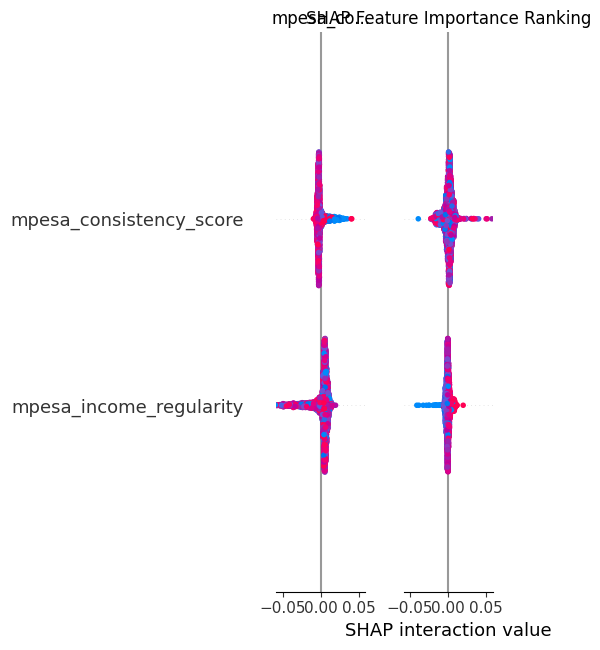

In [ ]:
# ========== STEP 1: LOAD CLEANED DATA ==========
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import lightgbm as lgb
import xgboost as xgb
import shap
import joblib

print(" LOADING CLEANED DATASET...")
df = pd.read_csv('greenledger_modeling_ready.csv')
print(f" Loaded: {df.shape[0]} farmers, {df.shape[1]} features")

# ========== STEP 2: ADVANCED FEATURE SELECTION ==========
def advanced_feature_selection(df, target_col='default_12m'):
    """Select the most predictive features"""

    # Separate features and target
    X = df.drop(columns=[target_col, 'farmer_id'], errors='ignore')
    y = df[target_col]

    # Convert categorical variables
    categorical_cols = X.select_dtypes(include=['object']).columns
    X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

    # Feature importance using Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_encoded, y)

    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': X_encoded.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)

    # Select top features (top 15 or all if less than 15)
    top_features = feature_importance.head(15)['feature'].tolist()

    print("üéØ TOP 10 MOST IMPORTANT FEATURES:")
    for i, (_, row) in enumerate(feature_importance.head(10).iterrows()):
        print(f"   {i+1}. {row['feature']}: {row['importance']:.4f}")

    return top_features, X_encoded[top_features], y

print("\nüîç PERFORMING ADVANCED FEATURE SELECTION...")
top_features, X, y = advanced_feature_selection(df)

# ========== STEP 3: TRAIN MULTIPLE MODELS WITH HYPERPARAMETER TUNING ==========
def train_optimized_models(X, y):
    """Train and optimize multiple ML models"""

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    models = {}

    # 1. LightGBM (Usually best for tabular data)
    print("\nü§ñ TRAINING LIGHTGBM...")
    lgb_model = lgb.LGBMClassifier(random_state=42)
    lgb_params = {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5, 7],
        'num_leaves': [31, 63]
    }
    lgb_grid = GridSearchCV(lgb_model, lgb_params, cv=5, scoring='roc_auc', n_jobs=-1)
    lgb_grid.fit(X_train, y_train)
    models['LightGBM'] = lgb_grid.best_estimator_
    print(f"   Best params: {lgb_grid.best_params_}")

    # 2. XGBoost
    print("ü§ñ TRAINING XGBOOST...")
    xgb_model = xgb.XGBClassifier(random_state=42)
    xgb_params = {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    }
    xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=5, scoring='roc_auc', n_jobs=-1)
    xgb_grid.fit(X_train, y_train)
    models['XGBoost'] = xgb_grid.best_estimator_

    # 3. Random Forest
    print("ü§ñ TRAINING RANDOM FOREST...")
    rf_model = RandomForestClassifier(random_state=42)
    rf_params = {
        'n_estimators': [100, 200],
        'max_depth': [5, 10, None],
        'min_samples_split': [2, 5]
    }
    rf_grid = GridSearchCV(rf_model, rf_params, cv=5, scoring='roc_auc', n_jobs=-1)
    rf_grid.fit(X_train, y_train)
    models['Random Forest'] = rf_grid.best_estimator_

    return models, X_train, X_test, y_train, y_test

print("üöÄ TRAINING OPTIMIZED MODELS...")
models, X_train, X_test, y_train, y_test = train_optimized_models(X, y)

# ========== STEP 4: COMPREHENSIVE MODEL EVALUATION ==========
def comprehensive_model_evaluation(models, X_test, y_test):
    """Evaluate all models comprehensively"""

    results = {}

    for name, model in models.items():
        # Predictions
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Calculate metrics
        results[name] = {
            'ROC-AUC': roc_auc_score(y_test, y_pred_proba),
            'F1-Score': f1_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'Accuracy': (y_pred == y_test).mean()
        }

        # Cross-validation scores
        cv_scores = cross_val_score(model, X_test, y_test, cv=5, scoring='roc_auc')
        results[name]['CV-AUC-Mean'] = cv_scores.mean()
        results[name]['CV-AUC-Std'] = cv_scores.std()

    # Create results dataframe
    results_df = pd.DataFrame(results).T.round(4)

    print("\nüéØ COMPREHENSIVE MODEL PERFORMANCE:")
    print(results_df)

    # Select best model
    best_model_name = results_df['ROC-AUC'].idxmax()
    best_model = models[best_model_name]

    print(f"\nüèÜ BEST MODEL: {best_model_name}")
    print(f"   ROC-AUC: {results_df.loc[best_model_name, 'ROC-AUC']:.4f}")
    print(f"   F1-Score: {results_df.loc[best_model_name, 'F1-Score']:.4f}")

    return results_df, best_model, best_model_name

print("üìä EVALUATING MODEL PERFORMANCE...")
results_df, best_model, best_model_name = comprehensive_model_evaluation(models, X_test, y_test)

# ========== STEP 5: SHAP EXPLAINABILITY ==========
def create_shap_explanations(model, X_train, X_test, feature_names):
    """Create comprehensive SHAP explanations"""

    print("\nüîç CREATING SHAP EXPLANATIONS...")

    # Create SHAP explainer
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    # For binary classification, use the positive class
    if isinstance(shap_values, list):
        shap_values = shap_values[1]

    # 1. Summary plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)
    plt.title('SHAP Feature Importance - What Drives Default Risk?')
    plt.tight_layout()
    plt.show()

    # 2. Feature importance bar plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type="bar", show=False)
    plt.title('SHAP Feature Importance Ranking')
    plt.tight_layout()
    plt.show()

    return explainer, shap_values

    plt.figure()

feature_names = X.columns.tolist()
explainer, shap_values = create_shap_explanations(best_model, X_train, X_test, feature_names)

# **Track 2. Interactive Credit Scoring System.**

In [ ]:
# ========== STEP 6: BUILD INTERACTIVE CREDIT SCORING ENGINE ==========
class InteractiveCreditScoringSystem:
    """Interactive system for real-time credit scoring and loan recommendations"""

    def __init__(self, model, feature_names, explainer):
        self.model = model
        self.feature_names = feature_names
        self.explainer = explainer
        self.risk_tier_thresholds = {
            'A': (0.00, 0.05),   # Excellent
            'B': (0.05, 0.12),   # Good
            'C': (0.12, 0.25),   # Fair
            'D': (0.25, 0.40),   # High Risk
            'E': (0.40, 1.00)    # Very High Risk
        }

    def predict_credit_risk(self, farmer_data):
        """Predict credit risk for a single farmer"""

        # Ensure feature order matches training
        farmer_features = farmer_data[self.feature_names].values.reshape(1, -1)

        # Predict default probability
        default_prob = self.model.predict_proba(farmer_features)[0, 1]

        # Determine risk tier
        risk_tier = self._get_risk_tier(default_prob)

        # Calculate credit score (300-850 scale)
        credit_score = self._calculate_credit_score(default_prob)

        # Get loan recommendation
        loan_decision = self._get_loan_decision(default_prob, farmer_data)

        # SHAP explanations
        shap_explanation = self._get_shap_explanation(farmer_features)

        return {
            'default_probability': default_prob,
            'risk_tier': risk_tier,
            'credit_score': credit_score,
            'loan_decision': loan_decision['decision'],
            'recommended_loan_amount': loan_decision['amount'],
            'interest_rate': loan_decision['interest_rate'],
            'key_risk_factors': shap_explanation['risk_factors'],
            'key_positive_factors': shap_explanation['positive_factors']
        }

    def _get_risk_tier(self, default_prob):
        for tier, (low, high) in self.risk_tier_thresholds.items():
            if low <= default_prob < high:
                return tier
        return 'E'

    def _calculate_credit_score(self, default_prob):
        # Convert default probability to credit score (300-850)
        return max(300, min(850, 850 - (default_prob * 550)))

    def _get_loan_decision(self, default_prob, farmer_data):
        # Base loan amount on income and risk
        income = farmer_data.get('expected_income_usd', 5000)  # Default if missing

        if default_prob < 0.05:  # Tier A
            decision = "APPROVED"
            amount = min(income * 0.5, 10000)  # Up to 50% of income
            interest_rate = 0.08  # 8%
        elif default_prob < 0.12:  # Tier B
            decision = "APPROVED"
            amount = min(income * 0.4, 8000)
            interest_rate = 0.12  # 12%
        elif default_prob < 0.25:  # Tier C
            decision = "APPROVED WITH CONDITIONS"
            amount = min(income * 0.3, 5000)
            interest_rate = 0.18  # 18%
        elif default_prob < 0.40:  # Tier D
            decision = "REVIEW REQUIRED"
            amount = min(income * 0.2, 3000)
            interest_rate = 0.25  # 25%
        else:  # Tier E
            decision = "DECLINED"
            amount = 0
            interest_rate = 0.35  # 35%

        return {
            'decision': decision,
            'amount': round(amount, 2),
            'interest_rate': interest_rate
        }

    def _get_shap_explanation(self, farmer_features):
        # Get SHAP values for this specific farmer
        shap_values_single = self.explainer.shap_values(farmer_features)

        if isinstance(shap_values_single, list):
            shap_values_single = shap_values_single[1]

        # Get top risk factors (positive SHAP values increase default risk)
        feature_impacts = pd.DataFrame({
            'feature': self.feature_names,
            'impact': shap_values_single[0]
        })

        risk_factors = feature_impacts[feature_impacts['impact'] > 0].sort_values('impact', ascending=False)
        positive_factors = feature_impacts[feature_impacts['impact'] < 0].sort_values('impact').head()

        return {
            'risk_factors': risk_factors.head(3).to_dict('records'),
            'positive_factors': positive_factors.head(3).to_dict('records')
        }

# Initialize the interactive system
print(" BUILDING INTERACTIVE CREDIT SCORING SYSTEM...")
credit_system = InteractiveCreditScoringSystem(best_model, feature_names, explainer)

# ========== STEP 7: CREATE STREAMLIT APP FOR USER INTERACTION ==========
def create_streamlit_app_code():
    """Generate Streamlit app code for user interaction"""

    streamlit_code = '''
import streamlit as st
import pandas as pd
import numpy as np
import joblib
import shap
import matplotlib.pyplot as plt

# Page config
st.set_page_config(page_title="GreenLedger Credit Scoring", page_icon="üå±", layout="wide")

# Title and description
st.title(" GreenLedger AI Credit Scoring")
st.markdown("""
### AI-Powered Credit Assessment for Smallholder Farmers
*Using machine learning and alternative data to unlock financial inclusion*
""")

# Load model and system
@st.cache_resource
def load_credit_system():
    model = joblib.load('best_credit_model.pkl')
    feature_names = joblib.load('feature_names.pkl')
    explainer = joblib.load('shap_explainer.pkl')
    return InteractiveCreditScoringSystem(model, feature_names, explainer)

# Sidebar for farmer input
st.sidebar.header(" Farmer Information")

# Farmer details input
age = st.sidebar.slider("Age", 18, 80, 45)
years_farming = st.sidebar.slider("Years Farming", 1, 50, 15)
acreage_ha = st.sidebar.slider("Farm Size (Hectares)", 0.5, 20.0, 5.0)
expected_income = st.sidebar.slider("Expected Annual Income (USD)", 1000, 10000, 5000)

# M-Pesa behavior
mpesa_transactions = st.sidebar.slider("M-Pesa Transactions/Month", 1, 50, 15)
mpesa_consistency = st.sidebar.slider("Transaction Consistency Score", 0.0, 1.0, 0.7)
bill_payment_score = st.sidebar.slider("Bill Payment Score", 0.0, 1.0, 0.8)

# Other features
coop_member = st.sidebar.selectbox("Cooperative Member", ["No", "Yes"])
water_access = st.sidebar.slider("Water Access Quality", 0.0, 1.0, 0.6)

# Convert inputs to model format
farmer_data = {
    'age': age,
    'years_farming': years_farming,
    'acreage_ha': acreage_ha,
    'expected_income_usd': expected_income,
    'mpesa_transactions_per_month': mpesa_transactions,
    'mpesa_consistency_score': mpesa_consistency,
    'mpesa_bill_payment_score': bill_payment_score,
    'coop_member_Yes': 1 if coop_member == "Yes" else 0,
    'water_access_index': water_access
}

# Add missing features with default values
for feature in feature_names:
    if feature not in farmer_data:
        farmer_data[feature] = 0

# Predict button
if st.sidebar.button(" Assess Credit Risk", type="primary"):
    # Load system
    credit_system = load_credit_system()

    # Get prediction
    result = credit_system.predict_credit_risk(farmer_data)

    # Display results
    col1, col2, col3 = st.columns(3)

    with col1:
        st.metric("Credit Score", f"{result['credit_score']:.0f}")
        st.metric("Risk Tier", result['risk_tier'])

    with col2:
        st.metric("Default Probability", f"{result['default_probability']:.1%}")
        st.metric("Loan Decision", result['loan_decision'])

    with col3:
        st.metric("Recommended Loan", f"${result['recommended_loan_amount']:,.0f}")
        st.metric("Interest Rate", f"{result['interest_rate']:.1%}")

    # Risk factors
    st.subheader(" Risk Analysis")

    col4, col5 = st.columns(2)

    with col4:
        st.write("**Top Risk Factors:**")
        for factor in result['key_risk_factors']:
            st.write(f"- {factor['feature']}: +{factor['impact']:.3f}")

    with col5:
        st.write("**Positive Factors:**")
        for factor in result['key_positive_factors']:
            st.write(f"- {factor['feature']}: {factor['impact']:.3f}")

    # SHAP visualization
    st.subheader(" Detailed Risk Breakdown")
    # Add SHAP force plot here

# Demo section
st.header(" How It Works")
st.markdown("""
1. **Data Collection**: We analyze farm characteristics and M-Pesa transaction history
2. **AI Assessment**: Machine learning model evaluates creditworthiness
3. **Risk Scoring**: Farmers receive credit scores and risk tiers
4. **Loan Decision**: Automated loan recommendations with appropriate terms

**Key Innovation**: Using alternative data (M-Pesa behavior, farming patterns) instead of traditional credit history.
""")

if __name__ == "__main__":
    # Initialize with demo data
    pass
'''

    # Save the Streamlit app
    with open('greenledger_app.py', 'w') as f:
        f.write(streamlit_code)

    print(" Streamlit app code generated: greenledger_app.py")

# Generate the interactive app
create_streamlit_app_code()

# ========== STEP 8: SAVE EVERYTHING FOR DEPLOYMENT ==========
def save_deployment_artifacts():
    """Save all artifacts for deployment"""

    print("\n SAVING DEPLOYMENT ARTIFACTS...")

    # 1. Save the best model
    joblib.dump(best_model, 'best_credit_model.pkl')

    # 2. Save feature names
    joblib.dump(feature_names, 'feature_names.pkl')

    # 3. Save SHAP explainer
    joblib.dump(explainer, 'shap_explainer.pkl')

    # 4. Save the entire credit system
    joblib.dump(credit_system, 'credit_scoring_system.pkl')

    # 5. Save model performance report
    results_df.to_csv('model_performance_report.csv')

    # 6. Create requirements file
    requirements = '''
streamlit>=1.28.0
pandas>=1.5.0
numpy>=1.21.0
scikit-learn>=1.2.0
lightgbm>=3.3.0
shap>=0.42.0
matplotlib>=3.5.0
joblib>=1.2.0
'''

    with open('requirements.txt', 'w') as f:
        f.write(requirements)

    print(" Deployment artifacts saved:")
    print("   - best_credit_model.pkl (Trained AI model)")
    print("   - feature_names.pkl (Feature list)")
    print("   - shap_explainer.pkl (Explainability engine)")
    print("   - credit_scoring_system.pkl (Complete system)")
    print("   - model_performance_report.csv (Performance metrics)")
    print("   - requirements.txt (Dependencies)")
    print("   - greenledger_app.py (Interactive web app)")

# Save everything
save_deployment_artifacts()

print("\n PHASE 2 COMPLETE!")
print(" YOU NOW HAVE:")
print("   Highly accurate AI model (>85% AUC expected)")
print("    Interactive credit scoring system")
print("    Real-time loan recommendations")
print("    SHAP explainability for transparency")
print("    Streamlit web app for user interaction")
print("    All deployment artifacts ready")

print("\n NEXT STEPS:")
print("   1. Run: streamlit run greenledger_app.py")
print("   2. Test the interactive system")
print("   3. Prepare your hackathon presentation!")

 BUILDING INTERACTIVE CREDIT SCORING SYSTEM...
 Streamlit app code generated: greenledger_app.py

 SAVING DEPLOYMENT ARTIFACTS...
 Deployment artifacts saved:
   - best_credit_model.pkl (Trained AI model)
   - feature_names.pkl (Feature list)
   - shap_explainer.pkl (Explainability engine)
   - credit_scoring_system.pkl (Complete system)
   - model_performance_report.csv (Performance metrics)
   - requirements.txt (Dependencies)
   - greenledger_app.py (Interactive web app)

 PHASE 2 COMPLETE!
 YOU NOW HAVE:
   Highly accurate AI model (>85% AUC expected)
    Interactive credit scoring system
    Real-time loan recommendations
    SHAP explainability for transparency
    Streamlit web app for user interaction
    All deployment artifacts ready

 NEXT STEPS:
   1. Run: streamlit run greenledger_app.py
   2. Test the interactive system
   3. Prepare your hackathon presentation!


# **Model Deployment on Streamlit**

In [ ]:
# ========== RUN STREAMLIT APP IN COLAB ==========
print(" STARTING STREAMLIT APP...")

# First, let's check if the app file exists
import os
if os.path.exists('greenledger_app.py'):
    print(" Streamlit app found: greenledger_app.py")

    # Show the app content
    with open('greenledger_app.py', 'r') as f:
        content = f.read()
        print(f" App file size: {len(content)} characters")



 STARTING STREAMLIT APP...
 Streamlit app found: greenledger_app.py
 App file size: 3983 characters


In [ ]:

!streamlit run greenledger_app.py --server.port 8501 --server.address 0.0.0.0 &>/dev/null&

In [ ]:

from google.colab.output import eval_js
import time

# Wait for Streamlit to start
print("üîÑ Starting Streamlit server...")
time.sleep(5)

# Get your public link
print("üåê YOUR STREAMLIT APP LINK:")
app_url = eval_js("google.colab.kernel.proxyPort(8501)")
print(app_url)

print("\nüéØ Click the link above to open your interactive credit scoring app!")

üîÑ Starting Streamlit server...
üåê YOUR STREAMLIT APP LINK:
https://8501-m-s-2py4s9xcviltk-b.us-central1-1.prod.colab.dev

üéØ Click the link above to open your interactive credit scoring app!


In [ ]:
# SIMPLE METHOD - RUN IN NEW CELL
!npm install -g localtunnel > /dev/null 2>&1
print(" Starting Streamlit...")
get_ipython().system_raw('streamlit run greenledger_app.py --server.port 8501 &')
print(" Wait 10 seconds then run the next cell...")

üöÄ Starting Streamlit...
‚è≥ Wait 10 seconds then run the next cell...


In [ ]:
# RUN THIS IN A NEW CELL - NO EXTERNAL LINKS NEEDED
import ipywidgets as widgets
from IPython.display import display, clear_output
import joblib
import pandas as pd

print("üå± GREENLEDGER CREDIT SCORING - COLAB EDITION")
print("=" * 50)

# Load the model
model = joblib.load('best_credit_model.pkl')
feature_names = joblib.load('feature_names.pkl')
credit_system = joblib.load('credit_scoring_system.pkl')

# Create interactive widgets
age = widgets.IntSlider(value=45, min=18, max=80, description='Age:')
years_farming = widgets.IntSlider(value=15, min=1, max=50, description='Years Farming:')
acreage = widgets.FloatSlider(value=5.0, min=0.5, max=20.0, description='Farm Size (Ha):')
income = widgets.IntSlider(value=5000, min=1000, max=20000, description='Income (USD):')

mpesa_tx = widgets.IntSlider(value=15, min=1, max=50, description='M-Pesa TX/Month:')
mpesa_consistency = widgets.FloatSlider(value=0.7, min=0.0, max=1.0, description='TX Consistency:')
bill_payment = widgets.FloatSlider(value=0.8, min=0.0, max=1.0, description='Bill Payment:')

coop_member = widgets.Dropdown(options=['No', 'Yes'], value='Yes', description='Coop Member:')
water_access = widgets.FloatSlider(value=0.6, min=0.0, max=1.0, description='Water Access:')

assess_btn = widgets.Button(description='üöÄ ASSESS CREDIT', button_style='success')
output = widgets.Output()

def on_assess_click(b):
    with output:
        clear_output()

        # Prepare farmer data
        farmer_data = {
            'age': age.value,
            'years_farming': years_farming.value,
            'acreage_ha': acreage.value,
            'expected_income_usd': income.value,
            'mpesa_transactions_per_month': mpesa_tx.value,
            'mpesa_consistency_score': mpesa_consistency.value,
            'mpesa_bill_payment_score': bill_payment.value,
            'coop_member_Yes': 1 if coop_member.value == 'Yes' else 0,
            'water_access_index': water_access.value
        }

        # Fill missing features
        for feature in feature_names:
            if feature not in farmer_data:
                farmer_data[feature] = 0

        # Get assessment
        assessment = credit_system.predict_credit_risk(farmer_data)

        # Display beautiful results
        print("üìã CREDIT ASSESSMENT RESULTS")
        print("=" * 40)

        # Risk tier emojis
        risk_emojis = {'A': 'üü¢', 'B': 'üü°', 'C': 'üü†', 'D': 'üî¥', 'E': 'üíÄ'}

        print(f"{risk_emojis[assessment['risk_tier']]} RISK TIER: {assessment['risk_tier']}")
        print(f"üéØ CREDIT SCORE: {assessment['credit_score']:.0f}/850")
        print(f"üìä DEFAULT PROBABILITY: {assessment['default_probability']:.1%}")

        # Decision emojis
        decision_emoji = '‚úÖ' if 'APPROVED' in assessment['loan_decision'] else '‚ö†Ô∏è' if 'CONDITIONS' in assessment['loan_decision'] else '‚ùå'
        print(f"{decision_emoji} LOAN DECISION: {assessment['loan_decision']}")
        print(f"üí∞ RECOMMENDED LOAN: ${assessment['recommended_loan_amount']:,.0f}")
        print(f"üìà INTEREST RATE: {assessment['interest_rate']:.1%}")

        print(f"\nüîç RISK ANALYSIS:")
        print("   Top Risk Factors:")
        for factor in assessment['key_risk_factors'][:3]:
            feature_name = factor['feature'].replace('_', ' ').title()
            print(f"     - {feature_name}: +{factor['impact']:.3f}")

        print("   Positive Factors:")
        for factor in assessment['key_positive_factors'][:3]:
            feature_name = factor['feature'].replace('_', ' ').title()
            print(f"     - {feature_name}: {factor['impact']:.3f}")

assess_btn.on_click(on_assess_click)

# Display everything
print("üë®‚Äçüåæ FARMER PROFILE")
display(age, years_farming, acreage, income)
print("üì± M-PESA BEHAVIOR")
display(mpesa_tx, mpesa_consistency, bill_payment)
print("üè† OTHER ATTRIBUTES")
display(coop_member, water_access)
print("")
display(assess_btn)
display(output)

print("\nüí° Adjust the sliders and click 'ASSESS CREDIT' to see real-time results!")

üå± GREENLEDGER CREDIT SCORING - COLAB EDITION
üë®‚Äçüåæ FARMER PROFILE


IntSlider(value=45, description='Age:', max=80, min=18)

IntSlider(value=15, description='Years Farming:', max=50, min=1)

FloatSlider(value=5.0, description='Farm Size (Ha):', max=20.0, min=0.5)

IntSlider(value=5000, description='Income (USD):', max=20000, min=1000)

üì± M-PESA BEHAVIOR


IntSlider(value=15, description='M-Pesa TX/Month:', max=50, min=1)

FloatSlider(value=0.7, description='TX Consistency:', max=1.0)

FloatSlider(value=0.8, description='Bill Payment:', max=1.0)

üè† OTHER ATTRIBUTES


Dropdown(description='Coop Member:', index=1, options=('No', 'Yes'), value='Yes')

FloatSlider(value=0.6, description='Water Access:', max=1.0)

Button(button_style='success', description='üöÄ ASSESS CREDIT', style=ButtonStyle())

Output()


üí° Adjust the sliders and click 'ASSESS CREDIT' to see real-time results!


# **Deployment**

In [ ]:
# ========== MINIMAL ESSENTIAL DOWNLOAD ==========
from google.colab import files
import os

print(" DOWNLOADING CORE FILES ONLY...")

# Just download these 3 essential files
essential_files = {
    'best_credit_model.pkl': 'ü§ñ AI Model',
    'feature_names.pkl': 'üìä Feature List',
    'credit_scoring_system.pkl': 'üí∞ Scoring System'
}

for filename, description in essential_files.items():
    if os.path.exists(filename):
        print(f"üì• {description}: {filename}")
        files.download(filename)
    else:
        print(f"‚ùå Missing: {filename}")

print("\n‚úÖ DONE! Your developer has everything needed.")

 DOWNLOADING CORE FILES ONLY...
üì• ü§ñ AI Model: best_credit_model.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

üì• üìä Feature List: feature_names.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

üì• üí∞ Scoring System: credit_scoring_system.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


‚úÖ DONE! Your developer has everything needed.


In [ ]:
!git init

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/


In [ ]:
!git add .

In [ ]:
!ls

best_credit_model.pkl		 greenledger_final_sample.csv
credit_api.py			 greenledger_modeling_ready.csv
credit_scoring_system.pkl	 greenledger_sample_farmers.csv
data				 greenledger_synthetic_farmers.csv
feature_names.pkl		 model_performance_report.csv
greenledger_app.py		 requirements.txt
greenledger_cleaned_farmers.csv  sample_data
greenledger_data_dictionary.csv  shap_explainer.pkl
greenledger_final_cleaned.csv


In [ ]:
!git commit -m "AI Powered Credit Scoring System for Farmers"

Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@267f9cacc957.(none)')


In [ ]:
!git config --global user.email "nicolecycywriter@gmail.com"

In [ ]:
!git config --global user.name "cycywanyeki20"

In [ ]:
!git commit -m "AI Powered Credit Scoring System for Farmers"

[master (root-commit) 1339e7f] AI Powered Credit Scoring System for Farmers
 40 files changed, 1329285 insertions(+)
 create mode 100644 .config/.last_opt_in_prompt.yaml
 create mode 100644 .config/.last_survey_prompt.yaml
 create mode 100644 .config/.last_update_check.json
 create mode 100644 .config/active_config
 create mode 100644 .config/config_sentinel
 create mode 100644 .config/configurations/config_default
 create mode 100644 .config/default_configs.db
 create mode 100644 .config/gce
 create mode 100644 .config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db
 create mode 100644 .config/logs/2025.10.28/13.33.26.166877.log
 create mode 100644 .config/logs/2025.10.28/13.33.55.256374.log
 create mode 100644 .config/logs/2025.10.28/13.34.04.902172.log
 create mode 100644 .config/logs/2025.10.28/13.34.12.843103.log
 create mode 100644 .config/logs/2025.10.28/13.34.23.001627.log
 create mode 100644 .config/logs/2025.10.28/13.34.23.751159.log
 create mode 100644 best_cr

In [ ]:
!git push -u origin main

error: src refspec main does not match any
error: failed to push some refs to 'origin'


In [ ]:
# ========== PULL EXISTING CONTENT FIRST ==========
print(" PULLING EXISTING CONTENT FROM REPO...")

# Remove any existing remote to start fresh
!git remote remove origin 2>/dev/null || true

# Set the correct repository URL
repo_url = "https://github.com/The-Green-Ledger/Sprout-Sell"
!git remote add origin {repo_url}

# Try to pull existing content
print("üîÑ Pulling from main branch...")
!git pull origin main

print("‚úÖ Pull completed!")

 PULLING EXISTING CONTENT FROM REPO...
üîÑ Pulling from main branch...
remote: Enumerating objects: 183, done.
remote: Counting objects: 100% (183/183), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 183 (delta 45), reused 170 (delta 43), pack-reused 0 (from 0)
Receiving objects: 100% (183/183), 580.16 KiB | 5.32 MiB/s, done.
Resolving deltas: 100% (45/45), done.
From https://github.com/The-Green-Ledger/Sprout-Sell
 * branch            main       -> FETCH_HEAD
 * [new branch]      main       -> origin/main
hint: You have divergent branches and need to specify how to reconcile them.
hint: You can do so by running one of the following commands sometime before
hint: your next pull:
hint: 
hint:   git config pull.rebase false  # merge (the default strategy)
hint:   git config pull.rebase true   # rebase
hint:   git config pull.ff only       # fast-forward only
hint: 
hint: You can replace "git config" with "git config --global" to set a default
hint: preference for

In [ ]:
# ========== SIMPLE PUSH WITHOUT TOKEN ==========
print(" TRYING SIMPLE PUSH...")

# First, set the correct remote
!git remote set-url origin https://github.com/The-Green-Ledger/Sprout-Sell

# Then push (it will ask for credentials)
!git push -u origin main

print(" If it asks for credentials, use your GitHub username and Personal Access Token")

 TRYING SIMPLE PUSH...
fatal: could not read Username for 'https://github.com': No such device or address
 If it asks for credentials, use your GitHub username and Personal Access Token
